In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from gurobipy import Model, GRB, quicksum, writeParams, setParam, read

In [2]:
relationship_mtx = pd.read_csv('../data/raw/Wedding Guest Network Data - Connection Matrix.csv', index_col=0)
constraint_mtx = pd.read_csv('../data/raw/Wedding Guest Network Data - Seating Constraints.csv', index_col=0)
guest_list_df = pd.read_csv('../data/raw/Wedding Guest Network Data - Guest List.csv', index_col=0)

In [3]:
relationship_mtx.index = ['_'.join(g.split(' ')) for g in relationship_mtx.index]
relationship_mtx.columns = ['_'.join(g.split(' ')) for g in relationship_mtx.columns]

constraint_mtx.index = ['_'.join(g.split(' ')) for g in constraint_mtx.index]
constraint_mtx.columns = ['_'.join(g.split(' ')) for g in constraint_mtx.columns]

In [4]:
constraint_mtx.fillna(0, inplace=True)

In [5]:
all(constraint_mtx.columns == relationship_mtx.columns) and all(constraint_mtx.index == relationship_mtx.index) and all(constraint_mtx.index == constraint_mtx.columns)

True

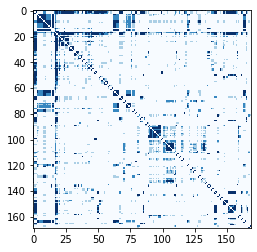

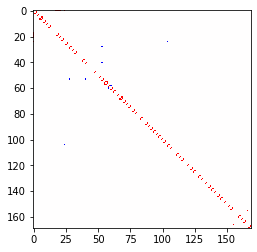

In [6]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.imshow(relationship_mtx.values, cmap='Blues', interpolation='nearest')
plt.show()

plt.imshow(constraint_mtx.values, cmap='bwr', interpolation='nearest')
plt.show()

In [7]:
guest_list = relationship_mtx.index.values.tolist()

In [8]:
len(guest_list)

169

In [9]:
for g in guest_list:
    for gp in guest_list:
        if gp == g:
            continue

        if relationship_mtx.loc[g, gp] != relationship_mtx.loc[gp, g]:
            print(f"relationship: {g} with {gp} does not match {gp} with {g}")

        if constraint_mtx.loc[g, gp] != constraint_mtx.loc[gp, g]:
            print(f"constraint: {g} with {gp} does not match {gp} with {g}")

In [10]:
guest_list_df.index = guest_list
age_difference_mtx = pd.DataFrame(0, columns=guest_list, index=guest_list)
for g in guest_list:
    for gp in guest_list:
        age_difference_mtx.loc[g, gp] = np.abs(guest_list_df.loc[g, 'age'] - guest_list_df.loc[gp, 'age'])

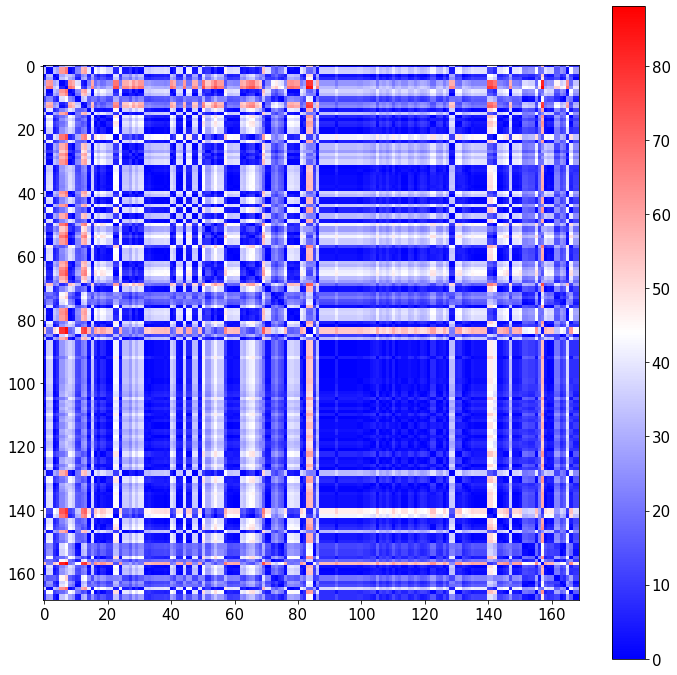

In [11]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15

plt.imshow(age_difference_mtx.values, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

In [12]:
# guest_list = np.random.choice(guest_list, size=150, replace=False)

In [19]:
guests_per_table = 8
age_difference_penalty = 0.1
must_sit_together_score = 1000
age_diff_zero = 5

In [20]:
tables = {
    f't_{t+1}': guests_per_table for t in range(len(guest_list)//guests_per_table + 1)
}

In [21]:
seating_model = Model()

In [22]:
y = seating_model.addVars(guest_list, tables.keys(), vtype=GRB.BINARY, name="y")

In [23]:
not_seated_together_list = []
for i, g in enumerate(guest_list):
    for gp in guest_list[i+1:]:

        if constraint_mtx.loc[g, gp] == 1:
            relationship_mtx.loc[g, gp] *= must_sit_together_score
            relationship_mtx.loc[gp, g] *= must_sit_together_score
        elif constraint_mtx.loc[g, gp] == -1:
            not_seated_together_list.append(('_'.join(g.split(' ')), '_'.join(gp.split(' '))))

In [24]:
relationship_mtx

,Richard_Pattison,Kathryn_Russell,Tim_Balzer,Mac_Pattison,Ali_Pattison,Ella_Pattison,Mary_Pattison,William_Pattison,Wally_Pattison,Holly_Pattison,...,Sean_Martin,Nefeli_Chondrogianni,Sean_Neel,Jenny_Falberg,Pat_Jr._Pattison,Morgan_Pattison,MC_Davault,Ryan_Hurley,Michael_Baldea,Guest_Baldea
Richard_Pattison,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,2.0,0.0
Kathryn_Russell,3.0,NaN,3000.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,3.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0
Tim_Balzer,3.0,3000.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,3.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0
Mac_Pattison,3.0,0.0,0.0,NaN,3000.0,3.0,3.0,3.0,3.0,3.0,...,1.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0
Ali_Pattison,3.0,0.0,0.0,3000.0,NaN,3.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Morgan_Pattison,2.0,0.0,0.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,...,0.0,0.0,0.0,0.0,3000.0,NaN,0.0,0.0,0.0,0.0
MC_Davault,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
Ryan_Hurley,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
Michael_Baldea,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3000.0


In [25]:
not_seated_together_list

[('Maggie_Dunn', 'James_Rogers'),
 ('Gordon_Carey', 'Robby_Mazza'),
 ('Rich_Lane', 'Robby_Mazza'),
 ('Tori_Iannuzzi', 'Mallory_Chandler')]

In [26]:
seating_model.setObjective(
    quicksum(
        quicksum(
            quicksum(
                (-relationship_mtx.loc[g, gp] + age_difference_penalty * (age_difference_mtx.loc[g, gp]) if age_difference_mtx.loc[g, gp] >= age_diff_zero else 0) * y[(g, table)] * y[(gp, table)] \
                    for table in tables.keys()) \
                for gp in guest_list[i+1:]) \
            for i, g in tqdm(enumerate(guest_list), total=len(guest_list))
    )
)

100%|██████████| 169/169 [00:18<00:00,  9.24it/s]


In [27]:
seating_model.addConstrs(quicksum(y[(g, table)] for g in guest_list) <= max_seats for table, max_seats in tables.items())

{('t_1', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_2', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_3', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_4', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_5', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_6', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_7', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_8', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_9', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_10', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_11', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_12', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_13', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_14', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_15', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_16', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_17', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_18', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('t_19', 8): <guro

In [28]:
seating_model.addConstrs(y[g, table] + y[gp, table] <= 1 for table in tables.keys() for g, gp in not_seated_together_list)

{('t_1',
  'Maggie_Dunn',
  'James_Rogers'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_1',
  'Gordon_Carey',
  'Robby_Mazza'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_1', 'Rich_Lane', 'Robby_Mazza'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_1',
  'Tori_Iannuzzi',
  'Mallory_Chandler'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_2',
  'Maggie_Dunn',
  'James_Rogers'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_2',
  'Gordon_Carey',
  'Robby_Mazza'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_2', 'Rich_Lane', 'Robby_Mazza'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_2',
  'Tori_Iannuzzi',
  'Mallory_Chandler'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_3',
  'Maggie_Dunn',
  'James_Rogers'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_3',
  'Gordon_Carey',
  'Robby_Mazza'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_3', 'Rich_Lane', 'Robby_Mazza'): <gurobi.Constr *Awaiting Model Update*>,
 ('t_3',
  'Tori_Iannuzzi',
  'Mallory_Chandler'): <gurobi.Cons

In [29]:
seating_model.addConstrs(quicksum(y[g, table] for table in tables.keys()) == 1 for g in guest_list)

{'Richard_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'Kathryn_Russell': <gurobi.Constr *Awaiting Model Update*>,
 'Tim_Balzer': <gurobi.Constr *Awaiting Model Update*>,
 'Mac_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'Ali_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'Ella_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'Mary_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'William_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'Wally_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'Holly_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'Daryl_Bammerlin': <gurobi.Constr *Awaiting Model Update*>,
 'Molly_Bammerlin': <gurobi.Constr *Awaiting Model Update*>,
 'Olivia_Bammerlin': <gurobi.Constr *Awaiting Model Update*>,
 'Harper_Bammerlin': <gurobi.Constr *Awaiting Model Update*>,
 'Austin_Giangeruso': <gurobi.Constr *Awaiting Model Update*>,
 'Mary_Grace_Pattison': <gurobi.Constr *Awaiting Model Update*>,
 'Troy_Nguyen': <gurobi.Constr 

In [37]:
# seating_model.optimize()

In [24]:
solution = {t: [] for t in tables.keys()}
for var in seating_model.getVars():
    if var.X == 1.0:
        guest, table = var.VarName.split('[')[1].split(']')[0].split(',')
        solution[table].append(' '.join(guest.split('_')))

In [25]:
solution

{'Table_1': ['Trish Davis',
  'Wendy Bell',
  'Debbie Roper',
  'Bonnie Neel',
  'Jukka Aromaa',
  'Sean Neel',
  'Gail Olson',
  'Gordon Carey'],
 'Table_2': ['Mary Campen',
  'Rick Strauss',
  'Suzie Campen',
  'Mac Pattison',
  'Jack Gretta',
  'Morgan Pattison'],
 'Table_3': ['Claire Meunier',
  'Mallory Chandler',
  'Cameron Berkowitz',
  'Nick Baltaxe',
  'Aaron Hoogstraten',
  'Andres Cifuentes',
  'Genevieve Geoghan',
  'Hunter Sullivan'],
 'Table_4': ['Jimmy Harvey',
  'Chris Donlon',
  'Angelo Morales',
  'Danielle Harvey',
  'Megan Kesselman',
  'Natalie Kanshanchi',
  'Savannah Rivers',
  'Cody Vild']}

In [32]:
setParam('TimeLimit', 60 * 60 * 7.5)

Set parameter TimeLimit to value 27000
Set parameter TimeLimit to value 27000


In [30]:
seating_model.update()

In [33]:
seating_model.write('../models/seating_model.mps')
writeParams('../models/seating_model.prm')

Wrote non-default parameter settings to file ../models/seating_model.prm


In [39]:
seating_model.update()

In [40]:
seating_model.read('../models/solutions/seating_model.sol')

In [41]:
seating_model.update()

In [45]:
seating_model.getVars()[0]

<gurobi.Var y[Richard_Pattison,t_1]>

In [47]:
read('../models/solutions/seating_model.sol')

Unknown file type for file '../models/solutions/seating_model.sol'


GurobiError: Unable to read model

In [30]:
sol_df = pd.read_csv('../models/solutions/seating_model2.csv')

In [31]:
solution = {t: [] for t in tables.keys()}
for idx, row in sol_df.iterrows():
    if row['Solution'] == 1:
        solution[row.Table].append(' '.join(row.Person.split('_')))

In [32]:
solution

{'t_1': ['Richard Pattison',
  'Max Balzer',
  'Devon Tucker',
  'Maggie Dunn',
  'Rich Lane',
  'Janet Lane',
  'Nick Baltaxe',
  'Claire Meunier'],
 't_2': ['Todd Demler',
  'James Rogers',
  'Brittany Zajic',
  'Cody Vild',
  'Jenny Rauch',
  'Gabe Rodriguez',
  'Natalie Kanshanchi',
  "Ryan O'Shea"],
 't_3': ['Sam Nicholson',
  'Saranna Soroka',
  'Molly Hamrick',
  'Aaron Hoogstraten',
  'Lauren Friedman',
  'Ryan Mowlds',
  'Morgan Nelson',
  'Cristina Andrade'],
 't_4': ['Mac Pattison',
  'Ali Pattison',
  'Ella Pattison',
  'Mary Pattison',
  'William Pattison',
  'Holly Pattison',
  'Daryl Bammerlin',
  'Olivia Bammerlin'],
 't_5': ['Molly Bammerlin',
  'Harper Bammerlin',
  'Mary Grace Pattison',
  'Pat Pattison',
  'Christie Ranges',
  'Andrew Campen',
  'Pete Ranges',
  'Pat Jr. Pattison'],
 't_6': ['Jake Bottiglieri',
  'Jim Geoghan',
  'Annie Geoghan',
  'Mark Roper',
  'Debbie Roper',
  'Caroline Pinkey',
  'Sloane Fowkes',
  'Mekaleya Fekade'],
 't_7': ['Genevieve Geogh